# Sampling trees

We show how to sample transmission trees. In the example below, the trees are generated using functions in IDM's `phylomodels` library. These functions process the linelist rendered by the branching process simulator to generate outptus that are formatted as ETE3 objects. Once we have the full tree, we evaluate two sampling methods, namely:
- random sampling, and
- stratified sampling

## Running a simulation

We import the Python packages that we are going to use, and initialize the simulation script by sourcing the `hiv_branching_process.R` file.

In [1]:
# Standard packages
import os
import math
import numpy as np
import pandas as pd
import seaborn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# IDM's phylomodels
from phylomodels.trees import generate_treeFromFile
from phylomodels.trees.transform_transToPhyloTree import transform_transToPhyloTree
from phylomodels.trees.transform_joinTrees import transform_joinTrees

# R-related packages
import rpy2
import rpy2.robjects as robjects
r = robjects.r

from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter


# We may need to install some packages
try:
    from rpy2.robjects.packages import importr
    dplyr = importr('dplyr')
except RRuntimeError:
    from rpy2.robjects.packages import importr, data
    utils = importr('utils')
    base = importr('base')
    utils.chooseCRANmirror()
    utils.install_packages('dplyr')


# Set up working directory
cwd = os.getcwd()
os.chdir('../')

In [2]:
r.source('hiv_branching_process.R')

value,[RTYPES.NILSXP]
visible,[RTYPES.LGLSXP]


In [3]:
# Run the simulation
out = r.simulate_transmission( sim_time=365*10 )
population_summary_r  = out.rx2('population_summary' )
transmission_record_r = out.rx2('transmission_record')

# Convert R dataframes into pandas dataframes
with localconverter( robjects.default_converter + pandas2ri.converter ):
    population_summary  = robjects.conversion.rpy2py( population_summary_r  )
    transmission_record = robjects.conversion.rpy2py( transmission_record_r )

# Let's define source and recipient id's as strings
population_summary['recipient'] = population_summary['recipient'].astype(int).astype(str)
population_summary['source'] = population_summary['source'].astype(int).astype(str)

# And let's also remove seed infections that didn't generate new infections
all_seeds = population_summary[ population_summary['source']=='0' ].index
all_infected_by_seed = population_summary[ population_summary['source'].isin( all_seeds ) ]
all_successful_seeds = all_infected_by_seed['source'].unique()
all_unsuccessful_seeds = list( set(all_seeds) - set(all_successful_seeds) )
population_summary_lean = population_summary.drop( index=all_unsuccessful_seeds )

  |==================================================| 100%


## Random sampling

The most basic scenario for sampling, is just choosing a random sample from the population. This type of sampling is parameterized by a single parameter, the sampling rate. Then, to sample trees we follow the next steps:
1. Select a list of sampled individuals from all transmitters in the population summary dataframe
2. Build the full transmission tree
3. Sample the tree by maintaining only the nodes that were selected in item 1, and making sure that branch lengths are preserved. 

Let's begin by creating the list of sampled individuas:

In [4]:
sampling_rate = 0.01

In [5]:
# Generate a random sample from the population
n_sampled = math.ceil( sampling_rate * len(population_summary_lean) )
sampled_individuals = np.random.choice( population_summary_lean['recipient'].values, size=n_sampled, replace=False )

# Let's check that sampling occurs after the last infection (not necessarily an error, 
# but, in general, we would expect an individual moving to treatment once it's found that is 
# infected)
for recipient in population_summary_lean['recipient']:
    infectees = population_summary_lean[ population_summary_lean['source']==recipient ]
    last_infection_time = infectees['infectionTime'].max()
    sample_time = population_summary_lean.loc[recipient, 'sampleTime']
    if sample_time < last_infection_time:
        import warnings
        warnings.warn( 'sampling time before last infection for id = %s' % recipient )

Now we can build and sample the transmission tree:

In [6]:
trees = generate_treeFromFile.read_treeFromLineList( population_summary,
                                                     ID = 'recipient',
                                                     infectorID = 'source',
                                                     infectTime = 'infectionTime',
                                                     sampleTime = 'sampleTime',
                                                     features = ['partners', 'acts_per_day', 'transmission_risk_per_act', 'removal_rate']
                                                   )
raw_tree = trees[0]

seeds = raw_tree.get_children()
seeds_phylo = []
for this_seed in seeds:
    seed_tree = transform_transToPhyloTree( this_seed )
    seeds_phylo.append( seed_tree )

tree = transform_joinTrees( seeds_phylo )
tree.describe()

Number of leaf nodes:	4260
Total number of nodes:	8519
Rooted:	Yes
Most distant node:	4012
Max. distance:	4896.467118


In [7]:
# Sample the tree
tree_sampled = tree.copy('deepcopy')
tree_sampled.prune( sampled_individuals.tolist(), preserve_branch_length=True )

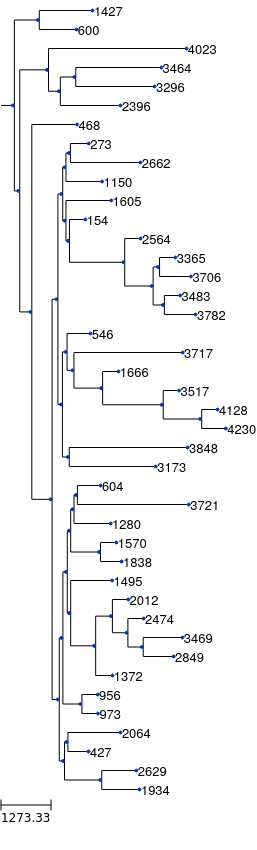

In [8]:
tree_sampled.render('%%inline')

## Stratified sampling

We can also sample the tree following a stratiefied sampling strategy, in which the samples are taking proportionally based on some categories. A stratified sampling function can be found at: https://github.com/InstituteforDiseaseModeling/phyloModels/blob/sampling/phylomodels/examples/sampling_stratified/Stratified%20Sampling.ipynb. We use this function here. Then, we will sample based on a category that discriminates high and low transmitters.

In [9]:
def stratified_sampler( data: pd.DataFrame,
                        feature,
                        strata,
                        proportions,
                        sample_size, 
                        debug = False
                       ):
    """Sample data with specific targets by strata (i.e., subgroup).
    
    Args:
        data        : Input dataframe.
        feature     : Name of column in `data` to be used for grouping into 
                      strata.
        strata      : List of strata or subgroups. Items in this list should 
                      be found in the `data` column specified by `feature`. 
                      Any values in the `feature` column that is not listed 
                      in `strata` will be grouped together as another 
                      stratum.
        proportions : List of proportions to sample from each item in 
                      `strata`. The proportions should be numbers between
                      0 and 1, and their sum must be less than or equal 
                      to 1.
        sample_size : Sampling fraction for the whole dataset. This is a
                      number between 0 and 1 than defines the total number
                      of samples to generate, based on the size of `data`.
        debug       : Boolean. Print progress and status messages.
        
    Returns:
        Indices of sampled rows from the input dataframe.
        Pandas DataFrame with sampled data.
        
    """
    
    # Read and analyze input data
    n = len(data)
    categories = data[feature].unique()
    unlisted_stratum = list( set(categories) - set(strata) )
    extended_strata = strata + unlisted_stratum
    proportions_sum = np.sum( np.array(proportions ))
    extended_proportions = np.array( proportions + [(1.0 - proportions_sum)] )
    if debug:
        print('... population size = ', n)
        print('... categories for ', feature, '= ', categories )
        print('... unlisted stratum = ', unlisted_stratum )
        print('... extended strata = ', extended_strata )
        print('... extended proportions = ', extended_proportions )
    
    
    # Validate parameters and data
    if proportions_sum > 1:
        raise ValueError('The sum of proportions must be less than or equal to 1')
    if np.sum(extended_proportions) < 1:
        warnings.warn('The sum of proportions is less than 1')
    if (sample_size < 0) or (sample_size > 1):
        raise ValueError('Sample size must be a number between 0 and 1')
    
    
        
    # Get number of samples for each stratum
    n_samples = np.around( extended_proportions * n * sample_size )
    if debug:
        print('... number of samples for each stratum = ', n_samples )

        
    # Do the actual sampling
    idx_samples = np.empty((0))
    for i, stratum in enumerate(extended_strata):
        stratum_population = data[ data[feature] == stratum ]
        idx_this_stratum = stratum_population.index.to_numpy()
        samples_this_stratum = np.random.permutation( idx_this_stratum )[0:int(n_samples[i])]
        idx_samples = np.concatenate( (idx_samples, samples_this_stratum) )
        if debug:
            print('... sampling for stratum = ', stratum)
            print('         idx_this_stratum = ', idx_this_stratum)
            print('         population size in this stratum = ', len(idx_this_stratum))
            print('         samples in this stratum = ', samples_this_stratum)
            print('         number of samples in this stratum = ', len(samples_this_stratum))

        
    # Prepare output and return
    sampled_data = data.iloc[idx_samples].copy()
    return idx_samples, sampled_data

In [10]:
# Let's create a category called 'high_transmitters'.  Individuals above the 0.8 quantile of transmission_risk_per_day belong to this category
high_transmitter_threshold = population_summary_lean['transmission_risk_per_day'].quantile(q=0.8)
population_summary_lean['high_transmitter'] = 0
population_summary_lean.loc[ population_summary_lean['transmission_risk_per_day'] > high_transmitter_threshold,
                             'high_transmitter' 
                            ] = 1

In [11]:
sampling_success = False
for i in range(10): # Trying to sample the tree several times because, in some cases
                    # we may not be able to generate the required propostion for a
                    # given class or strata
    try:
        sampled_individuals, _ = stratified_sampler( population_summary_lean,
                                                     feature     = 'high_transmitter',
                                                     strata      = [0  , 1  ],
                                                     proportions = [0.7, 0.3],
                                                     sample_size = sampling_rate, 
                                                     debug       = False
                                                    )
        sampling_success = True
        break
    except:
        pass
if sampling_success:
    print('The required sampling proportions were successfully generated in sampling trial #', i)
else:
    print('Unable to sample with the required proportions')

The required sampling proportions were successfully generated in sampling trial # 1


In [12]:
# Build a full tree
trees = generate_treeFromFile.read_treeFromLineList( population_summary,
                                                     ID = 'recipient',
                                                     infectorID = 'source',
                                                     infectTime = 'infectionTime',
                                                     sampleTime = 'sampleTime',
                                                     features = ['partners', 'acts_per_day', 'transmission_risk_per_act', 'removal_rate']
                                                   )
raw_tree = trees[0]

seeds = raw_tree.get_children()
seeds_phylo = []
for this_seed in seeds:
    seed_tree = transform_transToPhyloTree( this_seed )
    seeds_phylo.append( seed_tree )

tree = transform_joinTrees( seeds_phylo )

# Sample the tree
tree_sampled = tree.copy('deepcopy')
tree_sampled.prune( sampled_individuals.tolist(), preserve_branch_length=True )

In [13]:
# Tree formatting (for visualization)
import ete3

nstyle_transmitter = ete3.NodeStyle()
nstyle_transmitter['shape'  ] = 'sphere'
nstyle_transmitter['size'   ] = 11
nstyle_transmitter['fgcolor'] = 'darkred'

nstyle_lowtransmitter = ete3.NodeStyle()
nstyle_lowtransmitter['shape'  ] = 'sphere'
nstyle_lowtransmitter['size'   ] = 11
nstyle_lowtransmitter['fgcolor'] = 'blue'

nstyle_internal = ete3.NodeStyle()
nstyle_internal['shape'  ] = 'circle'
nstyle_internal['size'   ] = 6
nstyle_internal['fgcolor'] = 'gray'

for node in tree_sampled.traverse():    
    if node.name in population_summary_lean.index:
        nstyle = nstyle_transmitter if population_summary_lean.loc[ node.name, 'high_transmitter' ] else nstyle_lowtransmitter
        node.set_style( nstyle )
    else:
        node.set_style( nstyle_internal )

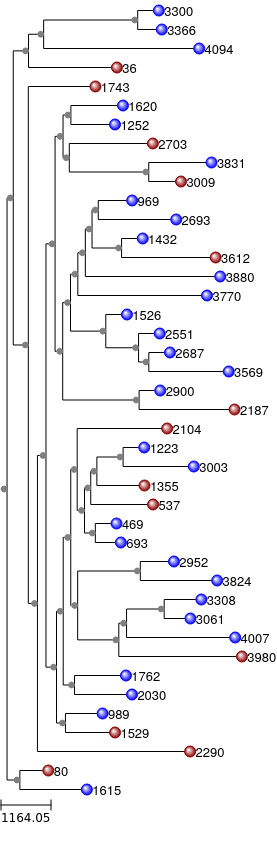

In [14]:
tree_sampled.render('%%inline')